In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
from datetime import timedelta
from pytz import timezone
import time

In [2]:
MARKET_TZ = timezone('US/Eastern')

def is_market_open(date):
    nyse = mcal.get_calendar('NYSE')
    sched = nyse.schedule(start_date=date, end_date=date)
    return not sched.empty

def get_next_trading_day(date):
    d = date
    while True:
        d += timedelta(days=1)
        if is_market_open(d):
            return d

def get_previous_trading_day(date):
    d = date
    while True:
        d -= timedelta(days=1)
        if is_market_open(d):
            return d

In [3]:
def get_historical_data(ticker, start_date, end_date, interval, max_retries=3, backoff_factor=2):
    """
    Retrieve historical data with retry logic for rate limits.
    Returns timezone-aware DataFrame in MARKET_TZ.
    """
    os.makedirs('historical_data', exist_ok=True)
    file_path = f'historical_data/{ticker}.csv'
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    for attempt in range(max_retries + 1):
        try:
            new_data = yf.download(ticker, 
                                 start=start_date,
                                 end=end_date,
                                 interval=interval,
                                 progress=False)
            
            if not new_data.empty:
                # Process columns and timezone
                if isinstance(new_data.columns, pd.MultiIndex):
                    new_data.columns = new_data.columns.get_level_values(0)
                    
                if new_data.index.tzinfo is None:
                    new_data.index = new_data.index.tz_localize(MARKET_TZ)
                else:
                    new_data.index = new_data.index.tz_convert(MARKET_TZ)
                
                return new_data
            
            return pd.DataFrame()  # Return empty if no data
            
        except Exception as e:
            if attempt < max_retries:
                wait_time = backoff_factor ** attempt
                print(f"Retry {attempt+1}/{max_retries} for {ticker} in {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"Failed to fetch {ticker} after {max_retries} retries: {str(e)}")
                return pd.DataFrame()
    
    return pd.DataFrame()

In [4]:
def get_stock_metrics(ticker):
    """Fetch fundamental data for a ticker"""
    try:
        tk = yf.Ticker(ticker)
        info = tk.info
        
        # Basic metrics
        metrics = {
            'Symbol': ticker,
            'Sector': info.get('sector', 'Unknown'),
            'Industry': info.get('industry', 'Unknown'),
            'MarketCap': info.get('marketCap', None),
            'Beta': info.get('beta', None),
            'PE': info.get('trailingPE', None),
            'ForwardPE': info.get('forwardPE', None),
            'PEG': info.get('pegRatio', None),
            'ShortPercentFloat': info.get('shortPercentOfFloat', None),
            'AvgVolume': info.get('averageVolume', None),
        }
        
        # Calculate market cap category
        mcap = metrics['MarketCap']
        if mcap:
            if mcap >= 200e9:
                metrics['CapSize'] = 'Mega'
            elif mcap >= 10e9:
                metrics['CapSize'] = 'Large'
            elif mcap >= 2e9:
                metrics['CapSize'] = 'Mid'
            elif mcap >= 300e6:
                metrics['CapSize'] = 'Small'
            else:
                metrics['CapSize'] = 'Micro'
        else:
            metrics['CapSize'] = 'Unknown'
            
        return metrics
    except Exception as e:
        print(f"Error fetching metrics for {ticker}: {str(e)}")
        return {'Symbol': ticker, 'Sector': 'Unknown', 'Industry': 'Unknown', 
                'CapSize': 'Unknown', 'MarketCap': None}

In [5]:
def get_eps_data(ticker):
    """Fetch and normalize EPS data from yfinance."""
    try:
        tk = yf.Ticker(ticker)
        # Try to get earnings dates, handle potential API changes
        try:
            df = tk.earnings_dates
        except (AttributeError, TypeError):
            # Fallback: try to get earnings history instead
            earnings_hist = tk.earnings_history
            if earnings_hist is not None and not earnings_hist.empty:
                df = earnings_hist
            else:
                # Second fallback: try calendar earnings
                try:
                    df = tk.calendar
                except:
                    return pd.DataFrame()
        
        if df is None or df.empty:
            return pd.DataFrame()
        
        # Processing steps remain the same
        df = df.reset_index()
        
        # Handle different column naming conventions
        rename_map = {}
        for col in df.columns:
            if 'earnings' in col.lower() and 'date' in col.lower():
                rename_map[col] = 'EarningsDate'
            elif 'estimate' in col.lower():
                rename_map[col] = 'Estimate'
            elif ('reported' in col.lower() and 'eps' in col.lower()) or ('actual' in col.lower()):
                rename_map[col] = 'Actual'
            elif 'surprise' in col.lower() and '%' in col:
                rename_map[col] = 'SurprisePct'
        
        # Only rename columns that exist
        existing_cols = {k: v for k, v in rename_map.items() if k in df.columns}
        if existing_cols:
            df = df.rename(columns=existing_cols)
        
        # Ensure required columns exist
        required_cols = ['EarningsDate', 'Estimate', 'Actual']
        if not all(col in df.columns for col in required_cols):
            return pd.DataFrame()
        
        # Parse dates
        if 'EarningsDate' in df.columns:
            df['EarningsDate'] = pd.to_datetime(df['EarningsDate']).dt.tz_localize(None).dt.date
        
        # Drop rows with missing data
        df = df.dropna(subset=['Estimate', 'Actual'])
        
        # Calculate SurprisePct if missing
        if 'SurprisePct' not in df.columns or df['SurprisePct'].isna().all():
            df['SurprisePct'] = (df['Actual'] - df['Estimate']) / df['Estimate'].abs() * 100
        
        # Return only needed columns
        return df[['EarningsDate', 'Estimate', 'Actual', 'SurprisePct']]
    
    except Exception as e:
        print(f"Error processing earnings data for {ticker}: {str(e)}")
        return pd.DataFrame()

In [6]:
def calculate_sue(eps_df):
    """Add Surprise and SUE columns."""
    eps = eps_df.copy()
    if len(eps) < 4:
        return eps

    eps['Surprise'] = eps['Actual'] - eps['Estimate']
    eps['SurpriseStd'] = (
        eps['Surprise']
           .rolling(window=4, min_periods=2)
           .std()
    )
    eps['SUE'] = eps['Surprise'] / eps['SurpriseStd'].replace(0, np.nan)
    return eps

In [7]:
def pre_earnings_strategy(ticker, earnings_date, days_before=7):
    """Buy or short N days before earnings based on the last SUE."""
    eps = get_eps_data(ticker)
    if eps.empty:
        return None

    eps = calculate_sue(eps)
    # Check if SUE calculation was possible
    if 'SUE' not in eps.columns:
        return None  # Not enough history to compute SUE

    # filter all rows strictly before this earnings_date
    hist = eps[eps['EarningsDate'] < earnings_date]
    if hist.empty:
        return None

    # pick the most recent SUE
    latest = hist.sort_values('EarningsDate').iloc[-1]
    sue = latest['SUE']
    if pd.isna(sue):
        return None

    # decide direction
    if sue > 1.0:
        direction = 'Long'
    elif sue < -1.0:
        direction = 'Short'
    else:
        return None

    # compute entry and exit dates
    entry = earnings_date
    for _ in range(days_before):
        entry = get_previous_trading_day(entry)
    exit = get_previous_trading_day(earnings_date)  # close the day before

    # fetch price data
    price = get_historical_data(
        ticker,
        start_date=entry - timedelta(days=10),
        end_date=earnings_date + timedelta(days=1),
        interval='1d'
    )
    if price.empty:
        return None

    # align to actual trading days
    entry_price = price.loc[price.index.date == entry, 'Close']
    exit_price  = price.loc[price.index.date == exit,  'Close']
    if entry_price.empty or exit_price.empty:
        return None

    ep = entry_price.iloc[0]
    xp = exit_price.iloc[0]
    ret = (xp - ep) / ep if direction == 'Long' else (ep - xp) / ep

    return {
        'Symbol':       ticker,
        'Strategy':     'Pre-Earnings',
        'Direction':    direction,
        'SUE':          float(sue),
        'Entry Date':   entry,
        'Entry Price':  float(ep),
        'Exit Date':    exit,
        'Exit Price':   float(xp),
        'Earnings Date': earnings_date,
        'Return':       ret,
        'Return %':     ret * 100
    }

In [8]:
def post_earnings_strategy(ticker, earnings_date, hold_days=30):
    """Trade N days after earnings based on SurprisePct."""
    eps = get_eps_data(ticker)
    if eps.empty:
        return None

    # find the exact earnings row
    rec = eps[eps['EarningsDate'] == earnings_date]
    if rec.empty:
        return None
    surprise = rec.iloc[0]['SurprisePct']

    # only trade if surprise is big
    if surprise > 5:
        direction = 'Long'
    elif surprise < -5:
        direction = 'Short'
    else:
        return None

    # entry is next trading day
    entry = get_next_trading_day(earnings_date)
    # exit is N trading days later
    exit = entry
    for _ in range(hold_days - 1):
        exit = get_next_trading_day(exit)

    price = get_historical_data(
        ticker,
        start_date=earnings_date - timedelta(days=5),
        end_date=exit + timedelta(days=5),
        interval='1d'
    )
    if price.empty:
        return None

    ep = price.loc[price.index.date == entry, 'Close']
    xp = price.loc[price.index.date == exit,  'Close']
    if ep.empty or xp.empty:
        return None
    ep, xp = ep.iloc[0], xp.iloc[0]

    ret = (xp - ep) / ep if direction == 'Long' else (ep - xp) / ep

    return {
        'Symbol':        ticker,
        'Strategy':      'Post-Earnings',
        'Direction':     direction,
        'Surprise(%)':   float(surprise),
        'Entry Date':    entry,
        'Entry Price':   float(ep),
        'Exit Date':     exit,
        'Exit Price':    float(xp),
        'Earnings Date': earnings_date,
        'Return':        ret,
        'Return %':      ret * 100
    }

In [9]:
# Script to run the backtest
tickers = [
    "SPG", "NRG", "FOXA", "KSPI", "MNDY", "SBS", "WTRG", "DVA", "SARO", "SRAD",
    "SWX", "SMR", "RDNT", "BCO", "MAC", "ZI", "POWI", "RGTI", "HBM", "SGRY",
    "SE", "JD", "ALC", "VG", "TME", "CYBR", "ONON", "EXEL", "LOAR",
    "CAE", "LEGN", "LSTR", "SLAB", "IGT", "CAMT", "UAA", "UA",
    "CSCO", "STE", "DT", "MMYT", "STN", "NXT", "GLBE", "CLBT",
    "TSEM", "DXC", "SRRK", "DLO", "HWKN",
    "WMT", "BABA", "DE", "AMAT", "NTES", "MFG", "TTWO", "BEKE",
    "BAP", "DOCS", "CAVA", "AEG", "BIRK", "WMS", "ZK", "GLOB",
    "MRX", "VEON", "BTDR",
    "SONY", "KB", "IX", "BSBR", "SHG", "SUZ",
    "RBC", "VFS", "MNSO", "CIG", "BRFS", "TGS",
    "FLO", "AKRO", "INTR", "UGP", "LPL", "RLX", "BHVN"
]
start_date = "2022-05-09"
end_date   = "2025-05-09"

all_trades = []

# Loop through tickers
for ticker in tickers:
    # Pull all earnings dates (with a little buffer for pre-earnings entries)
    buffer_start = pd.to_datetime(start_date) - timedelta(days=30)
    buffer_end   = pd.to_datetime(end_date)   + timedelta(days=30)

    earnings = get_eps_data(ticker)
    if earnings.empty:
        print(f"No earnings data for {ticker}, skipping.")
        continue

    # Filter to our window
    earnings = earnings[
        (earnings["EarningsDate"] >= buffer_start.date()) &
        (earnings["EarningsDate"] <= buffer_end.date())
    ]

    for ed in earnings["EarningsDate"]:
        # Pre‐Earnings
        pre = pre_earnings_strategy(ticker, ed, days_before=3)
        if pre:
            # only keep trades with entry in our true backtest window
            if start_date <= str(pre["Entry Date"])[:10] <= end_date:
                all_trades.append(pre)

        # Post‐Earnings
        post = post_earnings_strategy(ticker, ed, hold_days=10)
        if post:
            if start_date <= str(post["Entry Date"])[:10] <= end_date:
                all_trades.append(post)

# Build a DataFrame & inspect
if all_trades:
    results = pd.DataFrame(all_trades)
    results.sort_values("Entry Date", inplace=True)
    print("\n--- Sample Trades ---")
    print(results.head(10).to_string(index=False))

    # Simple performance summary
    total_ret   = results["Return"].sum()
    avg_ret     = results["Return"].mean()
    win_rate    = (results["Return"] > 0).mean()

    print(f"\nTotal P&L:    {total_ret:.4f} ({total_ret*100:.2f}%)")
    print(f"Avg per trade:{avg_ret:.4f} ({avg_ret*100:.2f}%)")
    print(f"Win Rate:     {win_rate:.2%}")
else:
    print("No trades generated in this period.")

YF.download() has changed argument auto_adjust default to True
Error processing earnings data for ZI: Failed to perform, curl: (35) Recv failure: Connection was reset. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


UACSCO: $UACSCO: possibly delisted; no earnings dates found


No earnings data for UACSCO, skipping.
No earnings data for SOBO, skipping.
No earnings data for UL, skipping.
No earnings data for TLK, skipping.


CIG.C: $CIG.C: possibly delisted; no earnings dates found


No earnings data for CIG.C, skipping.
No earnings data for ESGR, skipping.

--- Sample Trades ---
Symbol      Strategy Direction  Surprise(%) Entry Date  Entry Price  Exit Date  Exit Price Earnings Date    Return   Return %  SUE
   AEG Post-Earnings     Short       -53.66 2022-05-13     4.452652 2022-05-26    4.623251    2022-05-12 -0.038314  -3.831413  NaN
   AEG Post-Earnings     Short       -83.64 2022-08-12     4.404789 2022-08-25    4.067445    2022-08-11  0.076586   7.658567  NaN
   LPL Post-Earnings     Short      -117.84 2022-10-27     4.470000 2022-11-09    5.130000    2022-10-26 -0.147651 -14.765109  NaN
   HBM Post-Earnings      Long        15.38 2022-11-03     4.259860 2022-11-16    5.414401    2022-11-02  0.271028  27.102792  NaN
  INTR Post-Earnings      Long        67.95 2022-11-11     2.321674 2022-11-25    2.311878    2022-11-10 -0.004219  -0.421933  NaN
   AEG Post-Earnings      Long       186.90 2022-11-11     4.343355 2022-11-25    4.361156    2022-11-10  0.004098  

In [10]:
# Collect metrics for all tickers
all_metrics = []
for ticker in set(results['Symbol']):
    metrics = get_stock_metrics(ticker)
    all_metrics.append(metrics)

# Create metrics dataframe
metrics_df = pd.DataFrame(all_metrics)

In [11]:
all_trades_df = pd.DataFrame(all_trades)

In [19]:
# Merge with aggregated results
symbol_perf = pd.merge(
    all_trades_df, 
    metrics_df,
    on='Symbol'
)

In [20]:
cap_size_perf = symbol_perf.groupby('CapSize').agg({
    'Return': ['count', 'mean', 'sum', 'std'],
})
cap_size_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
cap_size_perf['Win Rate'] = symbol_perf.groupby('CapSize')['Return'].apply(
    lambda x: (x > 0).mean()
)
cap_size_perf['Profit Factor'] = symbol_perf.groupby('CapSize')['Return'].apply(
    lambda x: calculate_profit_factor(x.values)
)
print("\n--- Performance by Market Cap ---")
print(cap_size_perf)


--- Performance by Market Cap ---
         Count  Avg Return  Total Return   Std Dev  Win Rate  Profit Factor
CapSize                                                                    
Large      324    0.004390      1.422353  0.060833  0.540123       1.223233
Mega        17    0.004705      0.079990  0.034646  0.411765       1.494945
Mid        392    0.001516      0.594376  0.089057  0.533163       1.051860


In [14]:
sector_perf = symbol_perf.groupby('Sector').agg({
    'Return': ['count', 'mean', 'sum', 'std'],
})
sector_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
sector_perf['Win Rate'] = symbol_perf.groupby('Sector')['Return'].apply(
    lambda x: (x > 0).mean()
)
print("\n--- Performance by Sector ---")
print(sector_perf)


--- Performance by Sector ---
                        Count  Avg Return  Total Return   Std Dev  Win Rate
Sector                                                                     
Basic Materials            20    0.039820      0.796401  0.093350  0.700000
Communication Services     40    0.001811      0.072436  0.050751  0.575000
Consumer Cyclical         127    0.005459      0.693338  0.077480  0.535433
Consumer Defensive         35    0.014922      0.522277  0.049062  0.514286
Energy                     11    0.009214      0.101358  0.100418  0.363636
Financial Services         65   -0.001003     -0.065175  0.068881  0.538462
Healthcare                103   -0.007715     -0.794605  0.075597  0.475728
Industrials                72    0.013932      1.003096  0.065568  0.541667
Real Estate                28   -0.005593     -0.156600  0.086307  0.464286
Technology                199    0.001002      0.199449  0.089427  0.572864
Utilities                  33   -0.008341     -0.275257  

In [15]:
strategy_cap = symbol_perf.groupby(['Strategy', 'CapSize']).agg({
    'Return': ['count', 'mean', 'sum']
})
strategy_cap.columns = ['Count', 'Avg Return', 'Total Return']
print("\n--- Strategy by Market Cap ---")
print(strategy_cap)


--- Strategy by Market Cap ---
                       Count  Avg Return  Total Return
Strategy      CapSize                                 
Post-Earnings Large      195    0.002389      0.465780
              Mega         9    0.004653      0.041877
              Mid        261   -0.002702     -0.705236
Pre-Earnings  Large      129    0.007415      0.956574
              Mega         8    0.004764      0.038113
              Mid        131    0.009921      1.299611


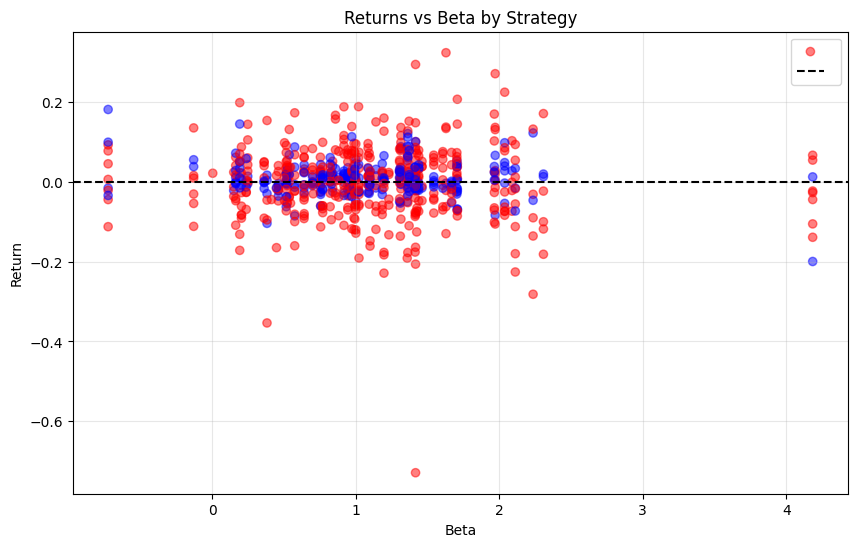

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(
    symbol_perf['Beta'], 
    symbol_perf['Return'],
    alpha=0.5, 
    c=symbol_perf['Strategy'].map({'Pre-Earnings': 'blue', 'Post-Earnings': 'red'})
)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Beta')
plt.ylabel('Return')
plt.title('Returns vs Beta by Strategy')
plt.legend(['', '', 'Pre-Earnings', 'Post-Earnings'])
plt.grid(True, alpha=0.3)
plt.show()


Performance Validity Analysis


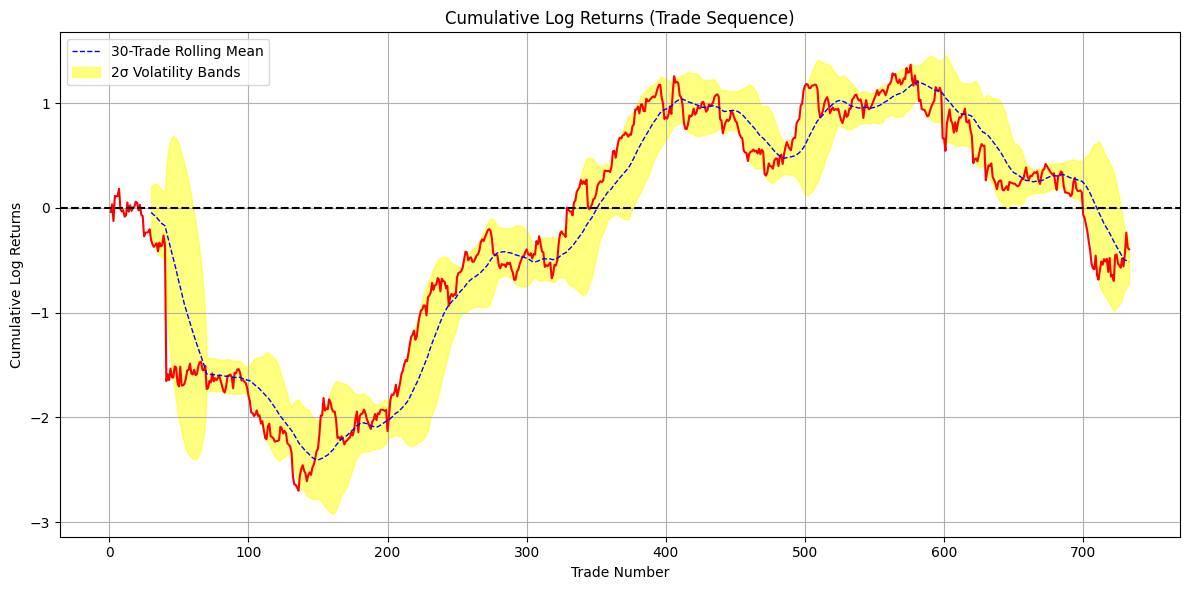

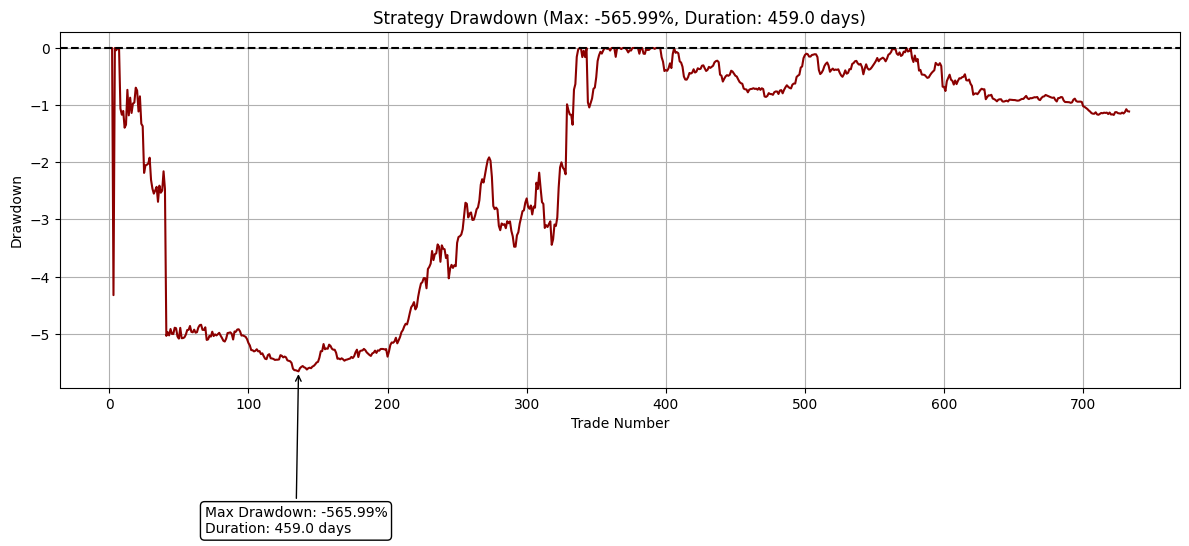

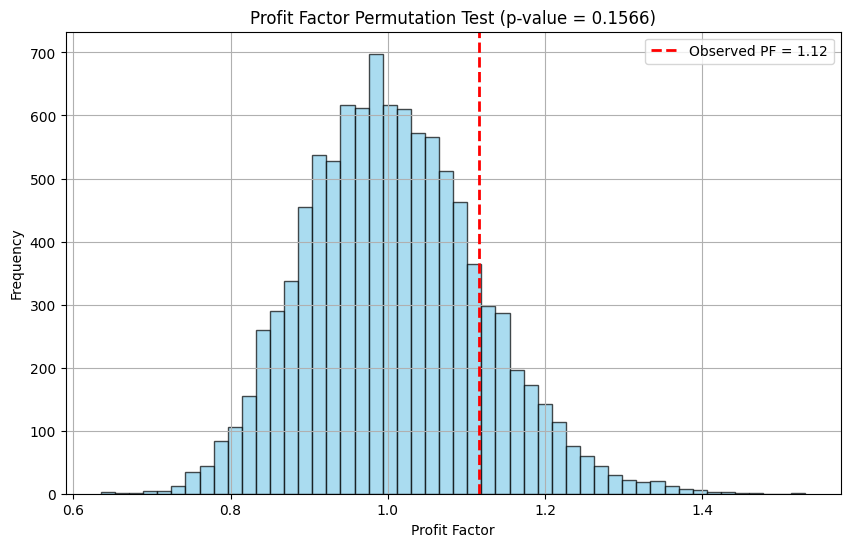


=== Profit Factor Permutation Test ===
Observed Profit Factor: 1.1165
Mean Permutation Profit Factor: 1.0062
P-value: 0.1566
Result: The observed profit factor is NOT statistically significant (p >= 0.05)

Profit Factor Permutation Test p-value: 0.1566
Result: Profit factor not statistically significant (p >= 0.05)

Return Distribution

--- Return Statistics ---
count    733.000000
mean       0.002860
std        0.076796
min       -0.728850
10%       -0.077919
25%       -0.028767
50%        0.004709
75%        0.037668
90%        0.082131
99%        0.195284
max        0.323567
Name: Return, dtype: float64

--- Worst Outcomes ---
   Worst 5.00%  Worst 1.00%
0    -0.112556     -0.19141


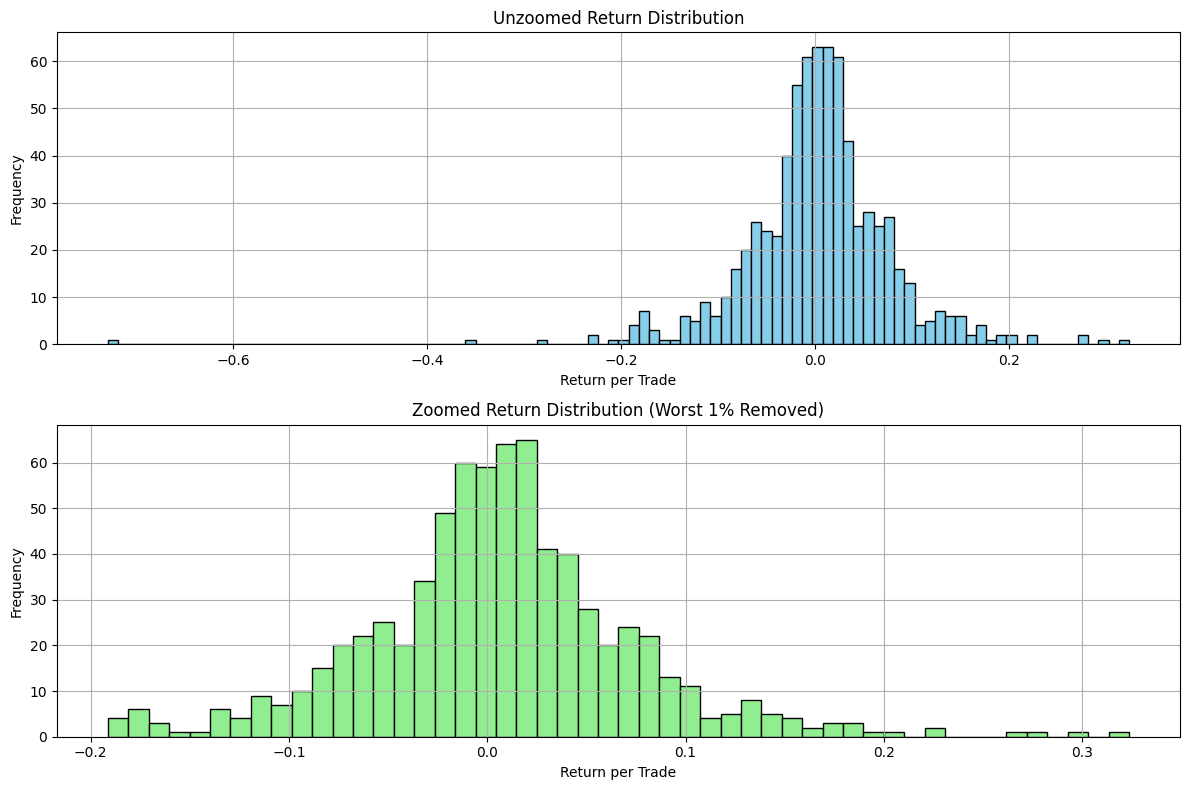


Strategy Analysis

--- Performance by Strategy ---
               Count  Avg Return  Total Return   Std Dev  Win Rate  \
Strategy                                                             
Post-Earnings    465   -0.000425     -0.197578  0.091383  0.516129   
Pre-Earnings     268    0.008561      2.294298  0.040064  0.563433   

               Profit Factor  
Strategy                      
Post-Earnings       0.987107  
Pre-Earnings        1.859368  


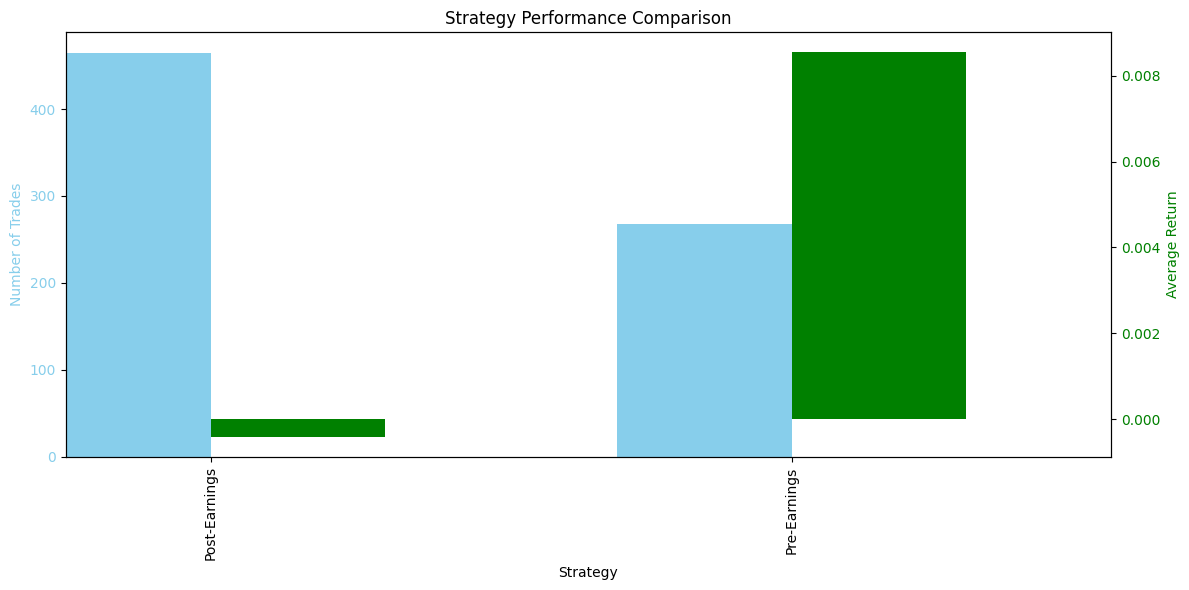


--- Performance by Direction ---
           Count  Avg Return  Total Return   Std Dev  Win Rate  Profit Factor
Direction                                                                    
Long         565    0.007983      4.510572  0.065930  0.550442       1.405614
Short        168   -0.014368     -2.413853  0.103844  0.476190       0.648843


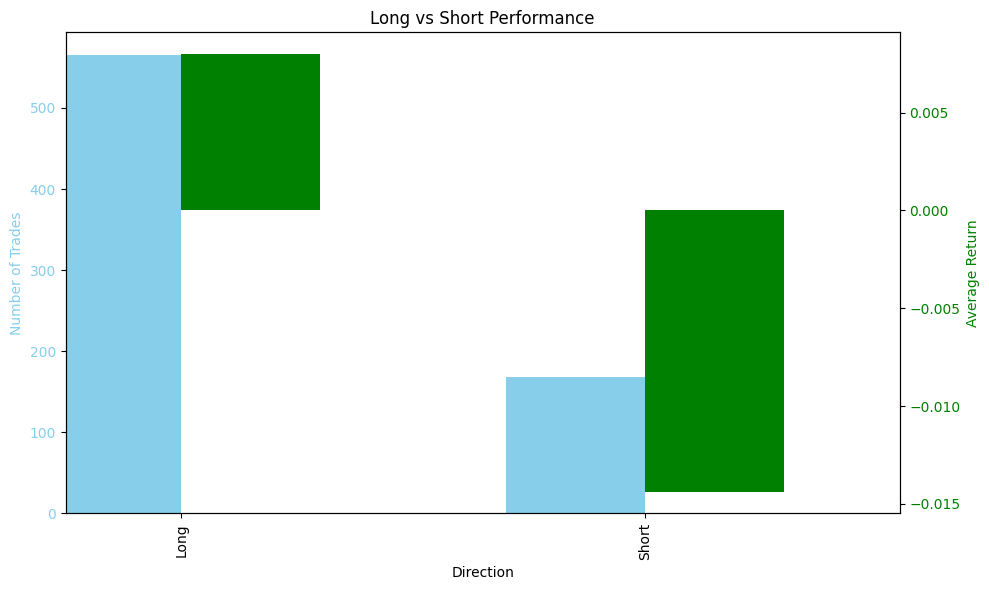


Kelly Criterion

--- Full Dataset Kelly Simulations ---

Kelly Fraction: 100%
count    1.000000e+04
mean     8.202020e+03
std      4.810851e+04
min      5.639809e-02
1%       1.706855e+00
10%      3.235429e+01
25%      1.453174e+02
50%      7.379837e+02
75%      3.369907e+03
90%      1.398542e+04
99%      1.256224e+05
max      1.914489e+06
dtype: float64


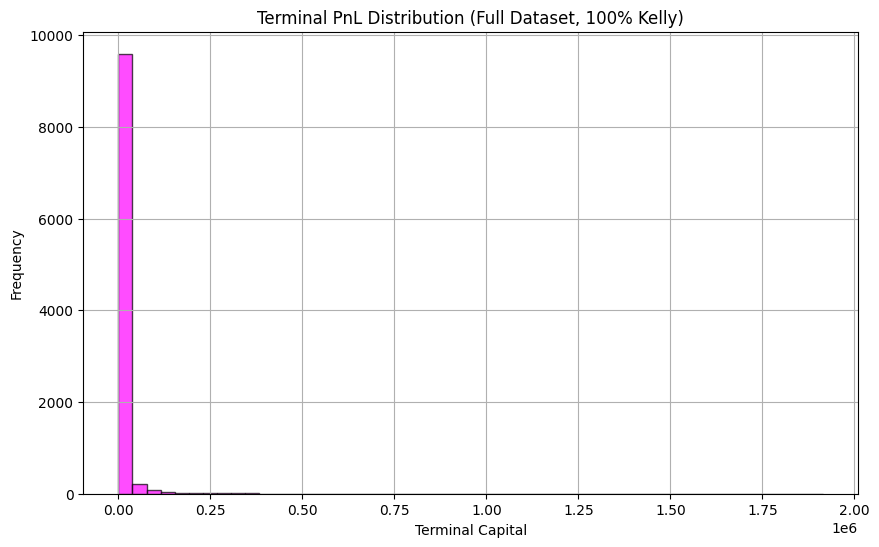

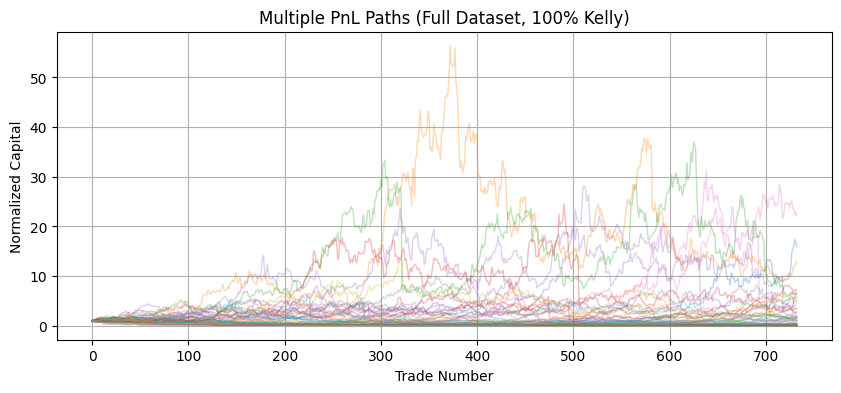


Kelly Fraction: 50%
count    10000.000000
mean      2893.067407
std       4025.399858
min         23.143896
1%         118.351970
10%        411.731603
25%        810.152546
50%       1646.194691
75%       3372.274985
90%       6575.629306
99%      18662.219518
max      70837.600392
dtype: float64


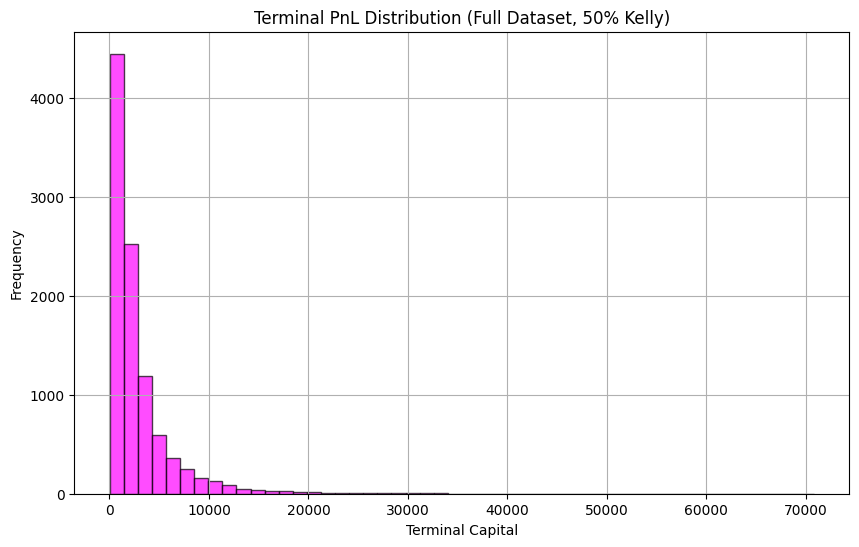

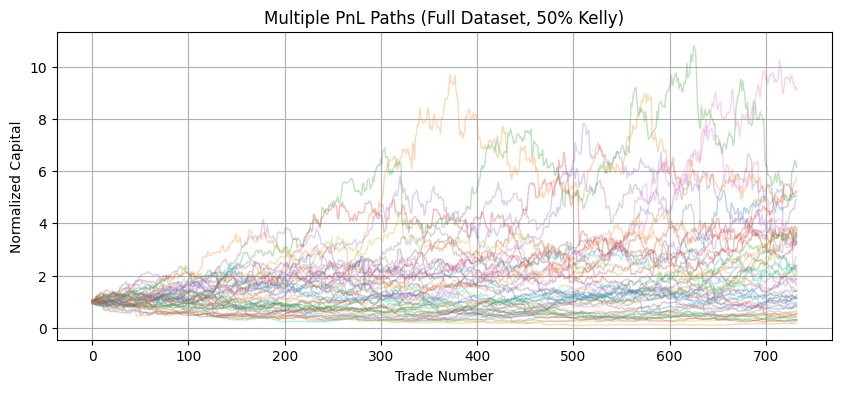


Kelly Fraction: 30%
count    10000.000000
mean      1889.138565
std       1310.886853
min        127.355410
1%         337.169099
10%        682.768102
25%       1017.580702
50%       1550.447957
75%       2364.688985
90%       3513.075459
99%       6522.748193
max      14487.006648
dtype: float64


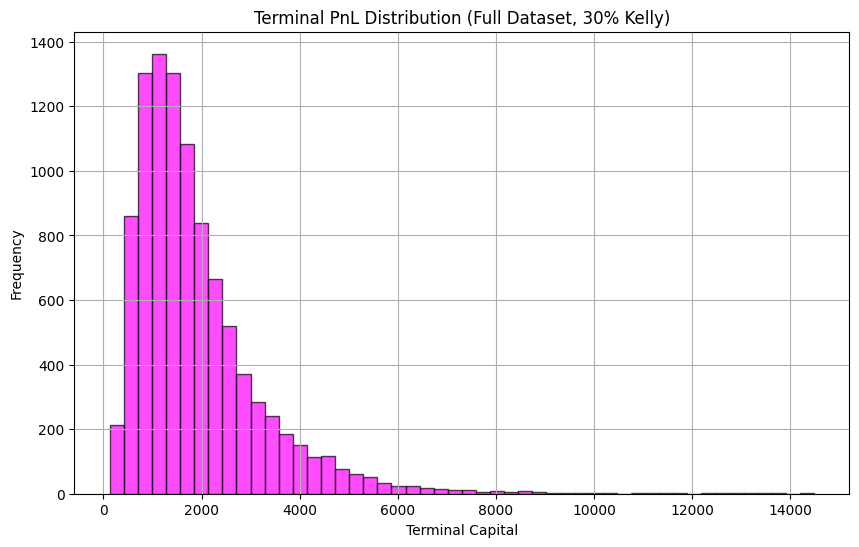

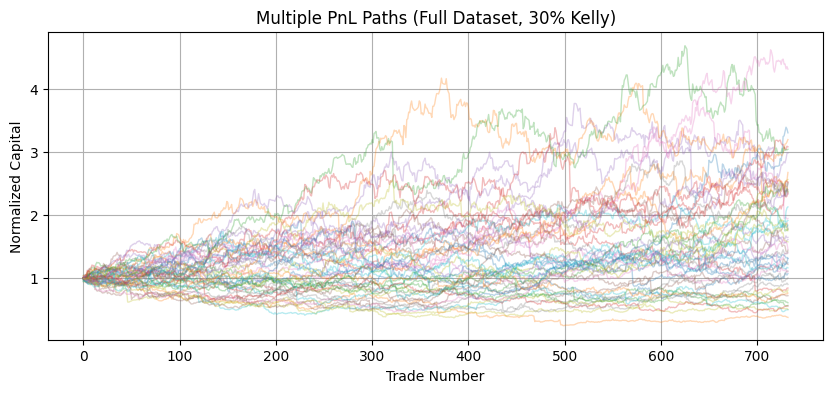


Symbol Analysis

--- Performance by Symbol ---
        Count  Avg Return  Total Return   Std Dev  Win Rate  Profit Factor
Symbol                                                                    
AEG         5   -0.006216     -0.031082  0.060175  0.600000       0.747610
AKRO        8    0.007224      0.057795  0.074661  0.625000       1.294630
ALC         8    0.004532      0.036260  0.027199  0.375000       1.696229
AMAT       13    0.025656      0.333533  0.034076  0.769231       5.675519
BABA        6   -0.012101     -0.072607  0.042107  0.333333       0.460304
...       ...         ...           ...       ...       ...            ...
WMS        12    0.018485      0.221823  0.037700  0.750000       3.346723
WMT        11    0.013872      0.152597  0.027787  0.454545       6.634897
WTRG        6    0.014219      0.085311  0.029859  0.666667       3.149270
ZI         10   -0.028127     -0.281268  0.070337  0.300000       0.295751
ZK          5    0.020944      0.104720  0.069391  0

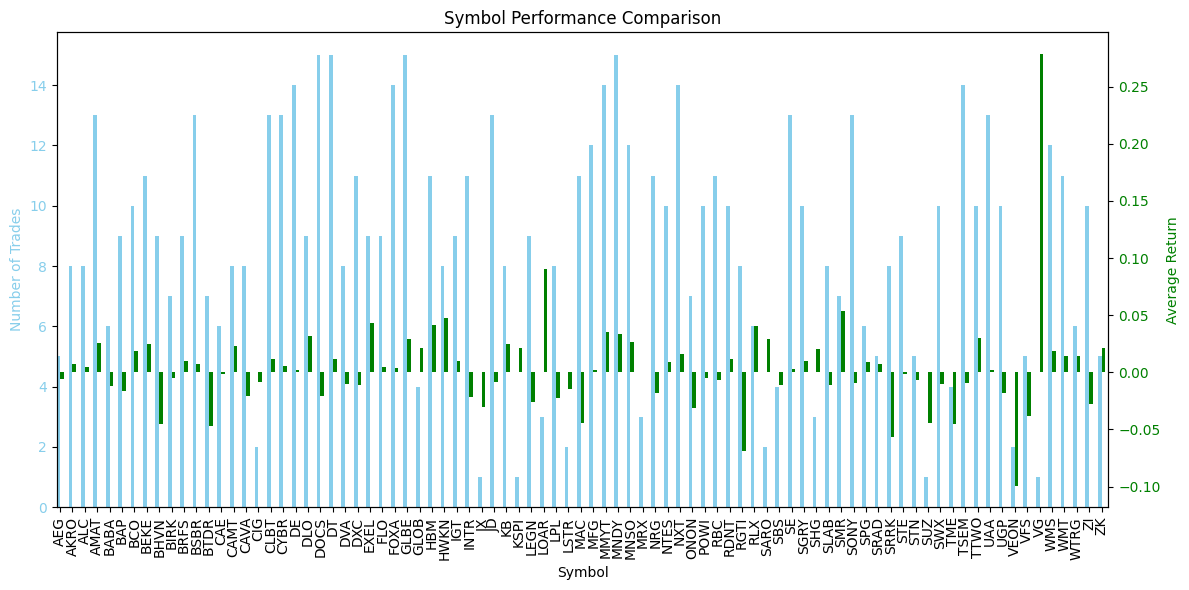

In [17]:
# Make sure results is not empty before performing analysis
if not results.empty:
    # -------------------------------
    # Performance Validity Checks
    # -------------------------------
    print("\n" + "="*40 + "\nPerformance Validity Analysis\n" + "="*40)

    # Convert to datetime for sorting (if not already)
    if 'Entry Date' in results.columns and not pd.api.types.is_datetime64_dtype(results['Entry Date']):
        results['Entry Date'] = pd.to_datetime(results['Entry Date'])
    
    # Sort results by entry date
    results.sort_values('Entry Date', inplace=True)

    # Create trade sequence index
    results['Trade Number'] = range(1, len(results)+1)

    # 1. Gap-Free Cumulative Returns Timeline
    plt.figure(figsize=(12, 6))
    cumulative_log_returns = np.log1p(results['Return']).cumsum()

    # Plot by trade sequence instead of calendar time
    plt.plot(results['Trade Number'], cumulative_log_returns, 
            color='red', linewidth=1.5)
    plt.title('Cumulative Log Returns (Trade Sequence)')
    plt.xlabel('Trade Number')
    plt.ylabel('Cumulative Log Returns')
    plt.grid(True)
    plt.axhline(0, color='black', linestyle='--')

    rolling_window = min(30, len(results) // 2) if len(results) > 4 else 2
    rolling_mean = cumulative_log_returns.rolling(rolling_window).mean()
    plt.plot(results['Trade Number'], rolling_mean,
            color='blue', linestyle='--', linewidth=1,
            label=f'{rolling_window}-Trade Rolling Mean')

    rolling_std = cumulative_log_returns.rolling(rolling_window).std()
    plt.fill_between(results['Trade Number'],
                    rolling_mean - 2*rolling_std,
                    rolling_mean + 2*rolling_std,
                    color='yellow', alpha=0.5,
                    label='2σ Volatility Bands')

    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Enhanced Drawdown Analysis
    plt.figure(figsize=(12, 6))
    cumulative_returns = np.exp(cumulative_log_returns) - 1
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak)/peak

    # Find maximum drawdown details
    max_dd = drawdown.min()
    max_dd_end_idx = drawdown.idxmin()
    max_dd_start_idx = drawdown[:max_dd_end_idx].idxmax()

    # Get actual datetime values from results
    max_dd_start_date = results.loc[max_dd_start_idx, 'Entry Date']
    max_dd_end_date = results.loc[max_dd_end_idx, 'Entry Date']

    # Calculate duration in days
    if isinstance(max_dd_start_date, pd.Timestamp) and isinstance(max_dd_end_date, pd.Timestamp):
        max_dd_duration = (max_dd_end_date - max_dd_start_date).days
    else:
        max_dd_duration = (pd.to_datetime(max_dd_end_date) - pd.to_datetime(max_dd_start_date)).days

    # Plot by trade sequence
    plt.plot(results['Trade Number'], drawdown, 
            color='darkred', linewidth=1.5)
    plt.title(f'Strategy Drawdown (Max: {max_dd:.2%}, Duration: {max_dd_duration:.1f} days)')
    plt.xlabel('Trade Number')
    plt.ylabel('Drawdown')
    plt.axhline(0, color='black', linestyle='--')

    max_dd_trade_num = results.loc[max_dd_end_idx, 'Trade Number']
    prev_trade_num = results.loc[max_dd_start_idx, 'Trade Number']

    plt.annotate(f'Max Drawdown: {max_dd:.2%}\nDuration: {max_dd_duration:.1f} days',
            xy=(max_dd_trade_num, max_dd),
            xytext=(max_dd_trade_num - (max_dd_trade_num - prev_trade_num)/2, 
                    max_dd*1.5),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black'))

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Helper function to calculate profit factor
def calculate_profit_factor(returns):
    """Calculate profit factor: sum of profits / sum of losses"""
    profits = returns[returns > 0].sum()
    losses = -returns[returns < 0].sum()  # Note the negative sign to make losses positive
    return profits / losses if losses > 0 else float('inf')

def perform_profit_factor_permutation_test(returns, n_permutations=10000):
    """
    Perform permutation test to evaluate statistical significance of profit factor
    
    Parameters:
    - returns: Array of trade returns
    - n_permutations: Number of permutations for the test
    
    Returns:
    - p-value of the observed profit factor
    """
    # Calculate the observed profit factor
    observed_pf = calculate_profit_factor(returns)
    
    # Initialize array to store permutation results
    permutation_pfs = np.zeros(n_permutations)
    
    # Perform permutation test by randomly flipping signs of returns
    np.random.seed(21)
    for i in range(n_permutations):
        # Generate random signs (-1 or 1) for each return
        random_signs = np.random.choice([-1, 1], size=len(returns))
        # Apply random signs to returns
        permuted_returns = returns * random_signs
        # Calculate profit factor for permuted returns
        permutation_pfs[i] = calculate_profit_factor(permuted_returns)
    
    # Calculate p-value: proportion of permuted PFs >= observed PF
    p_value = np.mean(permutation_pfs >= observed_pf)
    
    # Plot histogram of permutation results
    plt.figure(figsize=(10, 6))
    plt.hist(permutation_pfs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(observed_pf, color='red', linestyle='dashed', linewidth=2, label=f'Observed PF = {observed_pf:.2f}')
    plt.title(f'Profit Factor Permutation Test (p-value = {p_value:.4f})')
    plt.xlabel('Profit Factor')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print summary of permutation test
    print("\n=== Profit Factor Permutation Test ===")
    print(f"Observed Profit Factor: {observed_pf:.4f}")
    print(f"Mean Permutation Profit Factor: {np.mean(permutation_pfs):.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Result: The observed profit factor is statistically significant (p < 0.05)")
    else:
        print("Result: The observed profit factor is NOT statistically significant (p >= 0.05)")
    
    return p_value

# Only run if results exist
if not results.empty:
    # Extract returns array
    returns_array = results['Return'].values

    # Run permutation test (e.g., 10,000 permutations)
    p_value = perform_profit_factor_permutation_test(returns_array, n_permutations=10000)

    # Display p-value
    print(f"\nProfit Factor Permutation Test p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Result: Statistically significant profit factor (p < 0.05)")
    else:
        print("Result: Profit factor not statistically significant (p >= 0.05)")

    # -------------------------------
    # Return Distribution
    # -------------------------------
    print("\n" + "="*40 + "\nReturn Distribution\n" + "="*40)
    
    # Return Statistics
    print("\n--- Return Statistics ---")
    stats_df = results['Return'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])
    print(stats_df)
    
    # Worst Outcomes Table
    print("\n--- Worst Outcomes ---")
    worst_percentiles = [0.05, 0.01, 0.001]
    worst_returns = []
    worst_labels = []
    
    for p in worst_percentiles:
        if len(results) >= int(1/p):  # Only calculate if we have enough data
            worst_returns.append(results['Return'].quantile(p))
            worst_labels.append(f'Worst {p*100:.2f}%')
    
    if worst_returns:
        worst_df = pd.DataFrame([worst_returns], columns=worst_labels)
        print(worst_df)
    
    # Histograms for Return Distributions
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.hist(results['Return'], bins=min(100, len(results)//2), color='skyblue', edgecolor='black')
    plt.title('Unzoomed Return Distribution')
    plt.xlabel('Return per Trade')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    if len(results) >= 100:  # Only create zoomed view if enough data
        zoomed_data = results[results['Return'] > results['Return'].quantile(0.01)]
        plt.hist(zoomed_data['Return'], bins=min(50, len(zoomed_data)//2), color='lightgreen', edgecolor='black')
        plt.title('Zoomed Return Distribution (Worst 1% Removed)')
    else:
        plt.hist(results['Return'], bins=min(50, len(results)//2), color='lightgreen', edgecolor='black')
        plt.title('Return Distribution')
    plt.xlabel('Return per Trade')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Strategy Analysis
    print("\n" + "="*40 + "\nStrategy Analysis\n" + "="*40)
    
    # Performance by strategy type
    if 'Strategy' in results.columns:
        strategy_perf = results.groupby('Strategy').agg({
            'Return': ['count', 'mean', 'sum', 'std'],
        })
        
        strategy_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
        strategy_perf['Win Rate'] = results.groupby('Strategy')['Return'].apply(
            lambda x: (x > 0).mean()
        )
        strategy_perf['Profit Factor'] = results.groupby('Strategy')['Return'].apply(
            lambda x: calculate_profit_factor(x.values)
        )
        
        print("\n--- Performance by Strategy ---")
        print(strategy_perf)
        
        plt.figure(figsize=(12, 6))
        ax = plt.gca()
        
        # Bar chart for count
        strategy_perf['Count'].plot(kind='bar', color='skyblue', ax=ax, position=1, width=0.3)
        ax.set_ylabel('Number of Trades', color='skyblue')
        ax.tick_params(axis='y', labelcolor='skyblue')
        
        # Secondary axis for return
        ax2 = ax.twinx()
        strategy_perf['Avg Return'].plot(kind='bar', color='green', ax=ax2, position=0, width=0.3)
        ax2.set_ylabel('Average Return', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        
        plt.title('Strategy Performance Comparison')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Performance by direction (Long/Short)
    if 'Direction' in results.columns:
        dir_perf = results.groupby('Direction').agg({
            'Return': ['count', 'mean', 'sum', 'std'],
        })
        
        dir_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
        dir_perf['Win Rate'] = results.groupby('Direction')['Return'].apply(
            lambda x: (x > 0).mean()
        )
        dir_perf['Profit Factor'] = results.groupby('Direction')['Return'].apply(
            lambda x: calculate_profit_factor(x.values)
        )
        
        print("\n--- Performance by Direction ---")
        print(dir_perf)
        
        # Bar chart
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
        
        # Bar chart for count
        dir_perf['Count'].plot(kind='bar', color='skyblue', ax=ax, position=1, width=0.3)
        ax.set_ylabel('Number of Trades', color='skyblue')
        ax.tick_params(axis='y', labelcolor='skyblue')
        
        # Secondary axis for return
        ax2 = ax.twinx()
        dir_perf['Avg Return'].plot(kind='bar', color='green', ax=ax2, position=0, width=0.3)
        ax2.set_ylabel('Average Return', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        
        plt.title('Long vs Short Performance')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    # -------------------------------
    # Kelly Criterion Analysis
    # -------------------------------
    print("\n" + "="*40 + "\nKelly Criterion\n" + "="*40)
    
    def monte_carlo_kelly(returns, kelly_fraction=1.0, n_sims=10000):
        np.random.seed(69)
        all_terminal = []
        for _ in range(n_sims):
            sampled_returns = np.random.choice(returns, size=len(returns), replace=True)
            capital = 1000
            for ret in sampled_returns:
                capital *= (1 + kelly_fraction * ret)
            all_terminal.append(capital)
        return pd.Series(all_terminal)
    
    def plot_multiple_pnl_paths(returns, kelly_fraction=1.0, num_paths=100, label=''):
        plt.figure(figsize=(10, 4))
        for _ in range(num_paths):
            path = np.cumprod(1 + kelly_fraction * np.random.choice(returns, size=len(returns), replace=True))
            plt.plot(path, lw=1, alpha=0.3)  # thin lines with transparency
        plt.title(f'Multiple PnL Paths ({label}, {int(kelly_fraction*100)}% Kelly)')
        plt.xlabel('Trade Number')
        plt.ylabel('Normalized Capital')
        plt.grid(True)
        plt.show()
    
    # Run Kelly simulations with all data (no time-based segmentation since we have limited data)
    returns = results['Return'].values
    
    if len(returns) >= 10:  # Only run if we have enough trades
        print("\n--- Full Dataset Kelly Simulations ---")
        
        for fraction in [1.0, 0.5, 0.3]:
            terminal_pnl = monte_carlo_kelly(returns, kelly_fraction=fraction, n_sims=10000)
            
            # Stats Table for Terminal PnL
            stats_table = terminal_pnl.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])
            print(f"\nKelly Fraction: {int(fraction*100)}%")
            print(stats_table)
            
            # Histogram of Terminal Capital distribution
            plt.figure(figsize=(10, 6))
            plt.hist(terminal_pnl, bins=50, alpha=0.7, color='magenta', edgecolor='black')
            plt.title(f'Terminal PnL Distribution (Full Dataset, {int(fraction*100)}% Kelly)')
            plt.xlabel('Terminal Capital')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
        
            # Plot Multiple Simulation Paths (PnL Curves)
            plot_multiple_pnl_paths(returns, kelly_fraction=fraction, num_paths=50, label='Full Dataset')
    
    # -------------------------------
    # Symbol Analysis
    # -------------------------------
    if 'Symbol' in results.columns:
        print("\n" + "="*40 + "\nSymbol Analysis\n" + "="*40)
        
        symbol_perf = results.groupby('Symbol').agg({
            'Return': ['count', 'mean', 'sum', 'std'],
        })
        
        symbol_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
        symbol_perf['Win Rate'] = results.groupby('Symbol')['Return'].apply(
            lambda x: (x > 0).mean()
        )
        symbol_perf['Profit Factor'] = results.groupby('Symbol')['Return'].apply(
            lambda x: calculate_profit_factor(x.values) if (x < 0).any() else float('inf')
        )
        
        print("\n--- Performance by Symbol ---")
        print(symbol_perf)
        
        plt.figure(figsize=(12, 6))
        ax = plt.gca()
        
        # Bar chart for count
        symbol_perf['Count'].plot(kind='bar', color='skyblue', ax=ax, position=1, width=0.3)
        ax.set_ylabel('Number of Trades', color='skyblue')
        ax.tick_params(axis='y', labelcolor='skyblue')
        
        # Secondary axis for return
        ax2 = ax.twinx()
        symbol_perf['Avg Return'].plot(kind='bar', color='green', ax=ax2, position=0, width=0.3)
        ax2.set_ylabel('Average Return', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        
        plt.title('Symbol Performance Comparison')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("No trades found with the given strategy.")